In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import warnings
warnings.filterwarnings("ignore")
import TinySleepNet
import wandb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import DatasetsPaco
from wandb.keras import WandbCallback
from plotUtils import *

In [2]:
# wandb.init()

In [3]:
# parameters 
binary_labels = True
channels = ['F4', 'O2']
batch_size = 32
output_classes = 4 # <= non a mano?

In [4]:
train_dataset = DatasetsPaco.EDFData_GEN_TF("/media/usbdisk/data/ProyectoPSG/data/PSG1.edf", channels=channels)

In [6]:
# parameters <= da integrare in una util con l'our generator?
pts_per_epoch = train_dataset.epochs.get_data().shape[-1] # <= safe computarlo cosí? o da dentro la classe
sampling_rate = int(train_dataset.sampling_rate)

In [22]:
def our_generator():
    for x, y in train_dataset:
        yield x,y

train_dataset_generator = tf.data.Dataset.from_generator(our_generator,output_types=(tf.float64, tf.int32), output_shapes=(tf.TensorShape([pts_per_epoch,len(channels)]),tf.TensorShape([]))).batch(batch_size).shuffle(batch_size)

(<tf.Tensor: shape=(32, 15360, 2), dtype=float64, numpy=
 array([[[ 5.95124515e+00,  1.92619371e+00],
         [ 8.93234502e+00,  1.77987853e+00],
         [ 1.27415282e+01,  1.60917748e+00],
         ...,
         [-5.31068768e+00, -1.46604673e-01],
         [-6.63562095e+00, -2.89493759e-04],
         [ 1.14836203e+00,  7.28680961e-02]],
 
        [[ 7.27617843e+00, -1.46604673e-01],
         [ 1.22446782e+01, -3.66077443e-01],
         [ 1.48945448e+01, -6.09936076e-01],
         ...,
         [-2.49520447e+00,  3.16726729e-01],
         [-5.80753766e+00,  7.55672268e-01],
         [-1.06104208e+01,  1.04830263e+00]],
 
        [[ 8.93234502e+00,  1.41409058e+00],
         [ 7.44179509e+00,  1.26777540e+00],
         [ 5.28877852e+00,  1.14584608e+00],
         ...,
         [-6.47000429e+00,  1.34093299e+00],
         [-7.29808759e+00,  1.56040576e+00],
         [-5.31068768e+00,  1.73110680e+00]],
 
        ...,
 
        [[-1.92224871e+01,  2.92340866e-01],
         [-1.99835449e

In [9]:
test_dataset = DatasetsPaco.EDFData_GEN_TF("/media/usbdisk/data/ProyectoPSG/data/PSG4.edf", channels=channels)

def our_test_generator():
    for x, y in test_dataset:
        yield x, y

test_dataset_generator = tf.data.Dataset.from_generator(our_test_generator, output_types=(tf.float64, tf.int32), output_shapes=(tf.TensorShape([pts_per_epoch,len(channels)]),tf.TensorShape([]))).batch(batch_size).shuffle(batch_size)

In [11]:
val_dataset = DatasetsPaco.EDFData_GEN_TF("/media/usbdisk/data/ProyectoPSG/data/PSG5.edf", channels=channels)

def our_val_generator():
    for x, y in val_dataset:
        yield x, y

val_dataset_generator = tf.data.Dataset.from_generator(our_val_generator, output_types=(tf.float64, tf.int32), output_shapes=(tf.TensorShape([pts_per_epoch,len(channels)]),tf.TensorShape([]))).batch(batch_size).shuffle(batch_size)

In [12]:
# model = tf.keras.models.Sequential([
#         tf.keras.layers.Conv1D(128, 512//2, strides=512//4, input_shape=(15360, len(channels)), activation="relu"),
#         tf.keras.layers.Flatten(),
#         # tf.keras.layers.Dense(1, activation="sigmoid") =>
#         tf.keras.layers.Dense(output_classes, activation="softmax")
#     ])

# <=> ?

model = TinySleepNet.TinySleepNet(sampling_rate, len(channels), output_classes)

In [13]:
# model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy']) =>
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
history = model.fit(train_dataset_generator, epochs=50, validation_data=val_dataset_generator, callbacks=[WandbCallback()])
model.summary()

Epoch 1/5
20/20 [==============================] - 6s 160ms/step - loss: 7.1943 - accuracy: 0.3302 - val_loss: 84.8427 - val_accuracy: 0.2299
Epoch 2/5
20/20 [==============================] - 6s 143ms/step - loss: 3.5699 - accuracy: 0.5110 - val_loss: 172.0863 - val_accuracy: 0.3858
Epoch 3/5
20/20 [==============================] - 5s 138ms/step - loss: 6.9107 - accuracy: 0.5094 - val_loss: 159.5830 - val_accuracy: 0.0756
Epoch 4/5
20/20 [==============================] - 5s 147ms/step - loss: 4.8979 - accuracy: 0.5173 - val_loss: 240.5455 - val_accuracy: 0.5827
Epoch 5/5
20/20 [==============================] - 5s 132ms/step - loss: 7.0909 - accuracy: 0.4969 - val_loss: 87.0898 - val_accuracy: 0.5433
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 119, 128)          65664     
_________________________________________________________________
fla

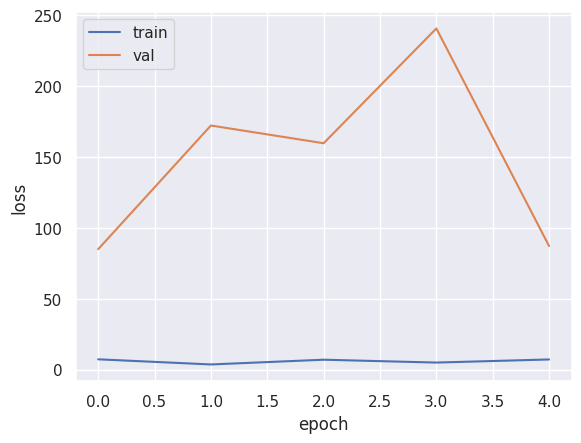

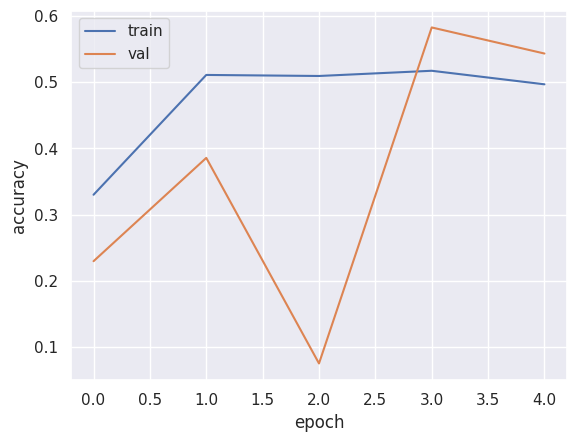

In [21]:
plot_history(history)

In [15]:
# test, pero sin cargarlo en memo => adapta il plot della cm
y_ = model.predict(test_dataset_generator)

# y_pred = np.array(y_.shape[0]*[1]) => binary
# y_pred[np.where(y_<0.5)[0]] = 0 => binary
y_pred = np.argmax(y_, axis=-1)

y_real = []
for x, y in test_dataset:
    y_real.append(y)
y_real = np.array(y_real)

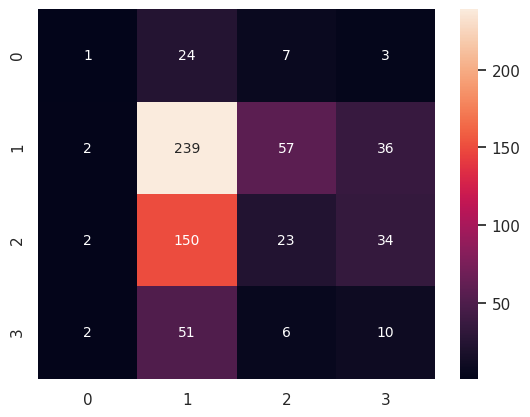

In [16]:
plot_cm(y_real, y_pred)